In [2005]:
# Import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL

# Reading aggregated dataset
df = pd.read_csv('/home/lavrenchuk/TS_Project_Favorita/data/processed/data.csv')

# Show the first and the last rows
display(df.head())
display(df.tail())

,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30847.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


,date,unit_sales
1682,2017-08-11,80783.227
1683,2017-08-12,77928.860
1684,2017-08-13,92090.859
1685,2017-08-14,69852.929
1686,2017-08-15,80080.046


## Daily granularity

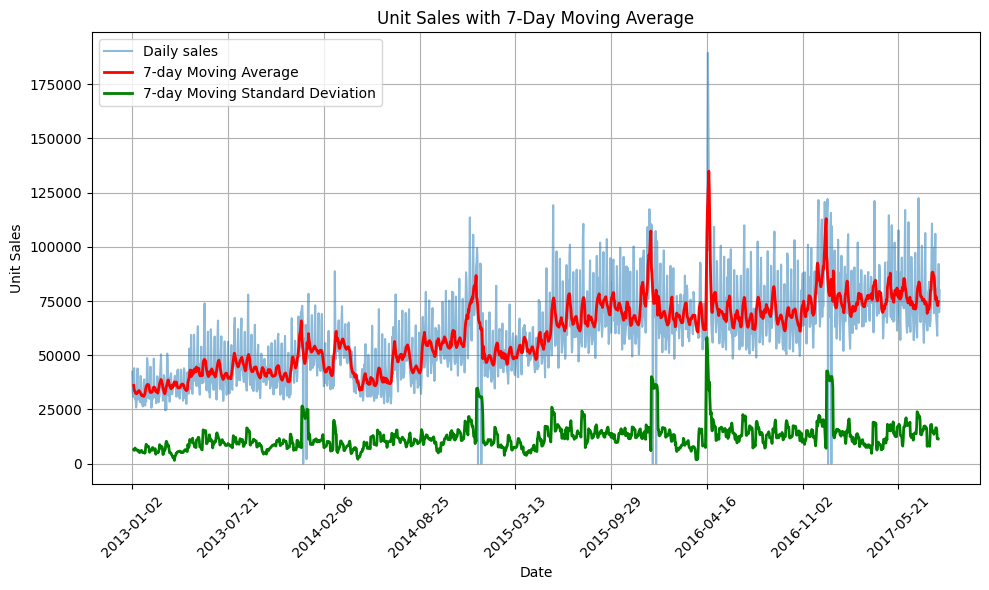

In [2006]:
# Visualization

sales_ma7 = df['unit_sales'].rolling(window=7, center=True).mean()
sales_std7 = df['unit_sales'].rolling(window=7, center=True).std()
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['unit_sales'], label='Daily sales', alpha=0.5)
plt.plot(df['date'], sales_ma7, color='red', linewidth=2, label='7-day Moving Average')
plt.plot(df['date'], sales_std7, color='green', linewidth=2, label='7-day Moving Standard Deviation')
plt.title('Unit Sales with 7-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(df['date'][::200], rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [2007]:
display(df.describe())
print(f'Null-values in the DataFrame:',(df["unit_sales"]==0).sum())
display(df.info())

,unit_sales
count,1687.000000
mean,59564.215215
std,20313.635596
min,0.000000
25%,44221.699000
50%,58616.714000
75%,71353.534500
max,189504.744000


Null-values in the DataFrame: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1687 non-null   object 
 1   unit_sales  1687 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.5+ KB


None

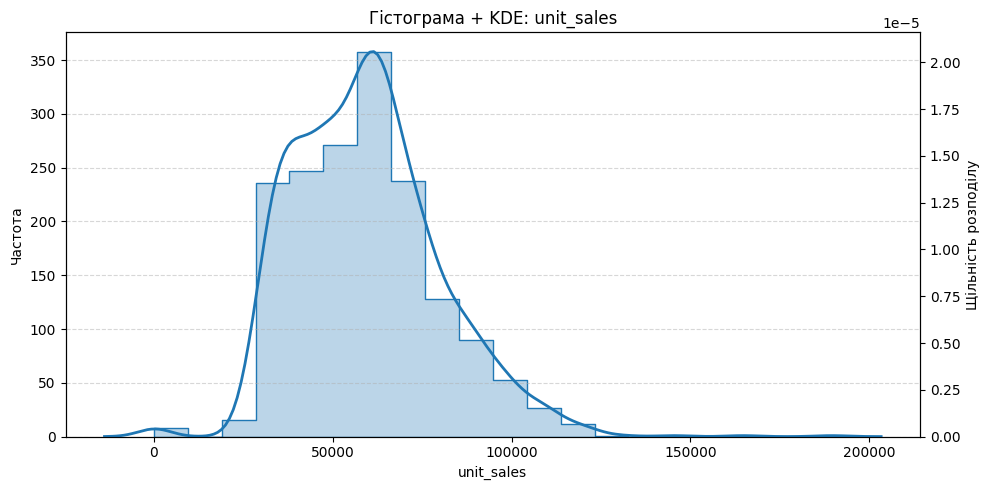

Median: 58616.714
Mean: 59564.22
Kurtosis coefficient: 1.48
Skewness coefficient: 0.68
Coefficient of Variation: 0.34


In [2008]:
col = "unit_sales"

fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(
    data=df,
    x=col,
    bins=20,
    stat="count",
    element="step",
    fill=True,
    alpha=0.3,
    ax=ax
)

ax2 = ax.twinx()
sns.kdeplot(
    data=df,
    x=col,
    lw=2,
    ax=ax2
)

ax.set_title(f"Гістограма + KDE: {col}")
ax.set_xlabel(col)
ax.set_ylabel("Частота")
ax2.set_ylabel("Щільність розподілу")
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Statistics
median_value = df['unit_sales'].median()
mean_value   = df['unit_sales'].mean()
kurtosis_value = kurtosis(df['unit_sales'])
skewness     = skew(df['unit_sales'].dropna())
cv = df['unit_sales'].std() / df['unit_sales'].mean()

print(f"Median: {median_value}")
print(f"Mean: {mean_value:.2f}")
print(f"Kurtosis coefficient: {kurtosis_value:.2f}") 
print(f"Skewness coefficient: {skewness:.2f}") 
print(f"Coefficient of Variation: {cv:.2f}") 

## Year granularity


Years in dataset:
 [2013 2014 2015 2016 2017]


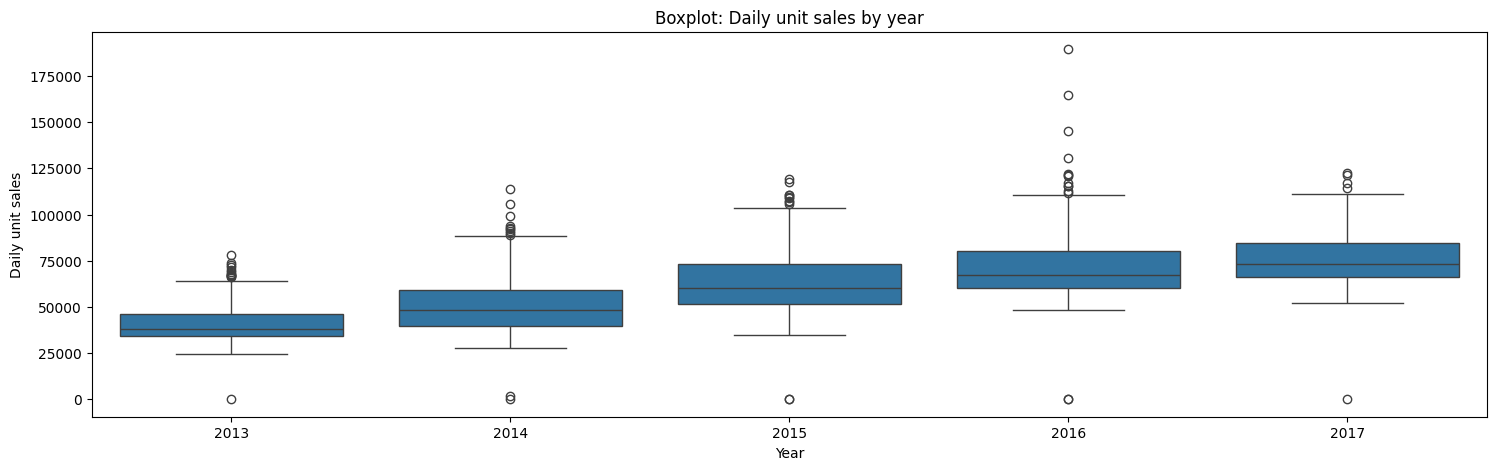

In [2009]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

print("\nYears in dataset:\n", df['year'].unique())

# built boxplot
plt.figure(figsize=(18,5))
sns.boxplot(data=df, x='year', y='unit_sales')
plt.title('Boxplot: Daily unit sales by year')
plt.xlabel('Year')
plt.ylabel('Daily unit sales')
plt.show()

## Weekly sesonality

In [2010]:
print(df.index)   #control of index

RangeIndex(start=0, stop=1687, step=1)


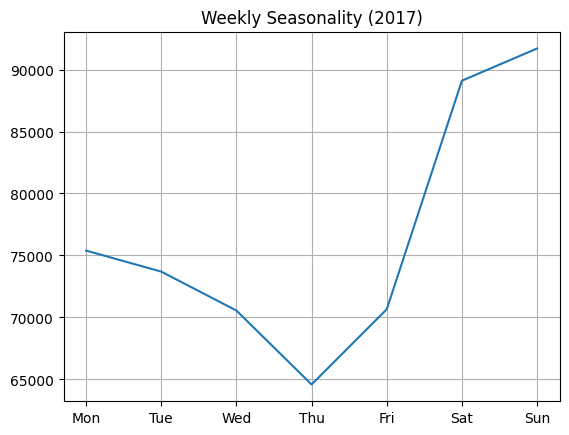

In [2011]:
# 1. Convert to datetime
df["date"] = pd.to_datetime(df["date"])
# 2. Set "date" as index
df = df.set_index("date")

# 3. Create colums "weekday" and "year"
df['weekday'] = df.index.dayofweek  # 0=Mon, 6=Sun
df['year'] = df.index.year

# 4. Choose one zear as an example
df_2017 = df[df['year'] == 2017]

# 5. Group date by type of day
weekly_pattern = df_2017.groupby('weekday')['unit_sales'].mean()
# print(weekly_pattern)

# 6. Build plot for weekly patterns
plt.plot(weekly_pattern)
plt.xticks(ticks=range(7), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Weekly Seasonality (2017)")
plt.grid()
plt.show()

## Weekdays vs Weekends

In [2012]:
# print(df.index)

([<matplotlib.axis.XTick at 0x787571b68770>,
 [Text(0, 0, 'Weekend'), Text(1, 0, 'Workday')])

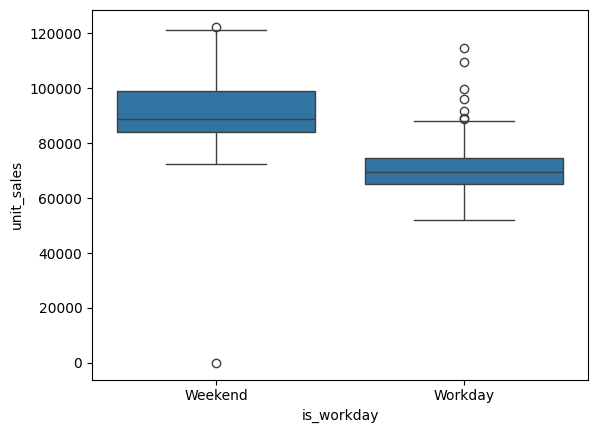

In [2013]:
# 1. Create "Workday" column 
df["is_workday"] = df["weekday"] <=4  # [Mon, Tue, Wed, Thu, Fri] => True, [Sat, Sun]-> False.

# 2. Choose one year as an example
df_2017 = df[df['year'] == 2017]

# 3. Build plot for weekly patterns
sns.boxplot(data=df_2017, x='is_workday', y='unit_sales')
plt.xticks([0,1], ['Weekend', 'Workday'])

## Monthly granularity

In [2014]:
# print(df.index)

/tmp/ipykernel_45287/2927863564.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_avg = df.resample('M').mean()


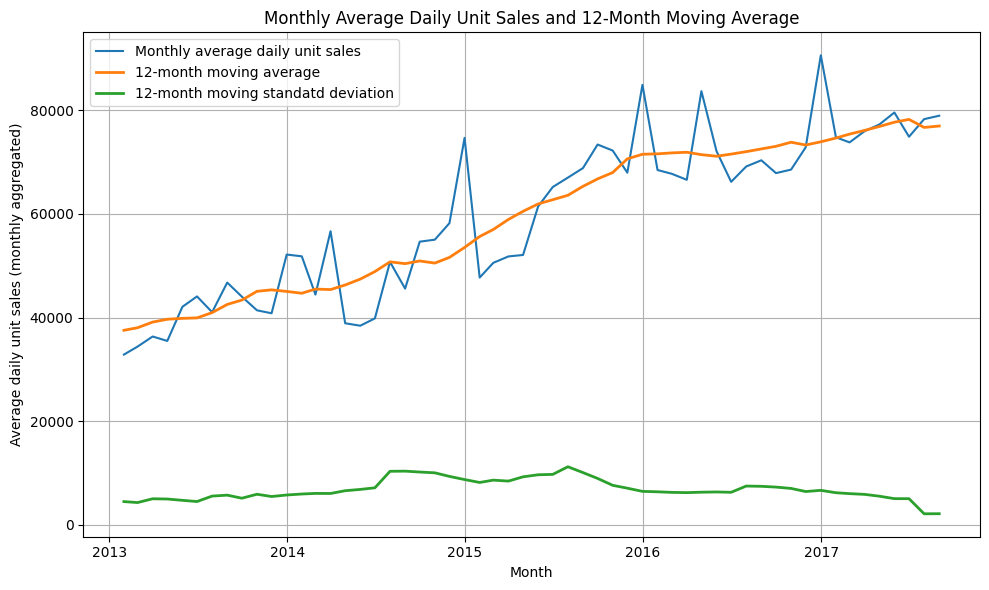

In [2015]:

# 1. Monthly average (daily unit sales aggregated to month level)
df['month'] = df.index.month 
df_monthly_avg = df.resample('M').mean()

# 2. 12-month rolling average and std
df_monthly_avg['unit_sales_ma_12'] = df_monthly_avg['unit_sales'].rolling(window=12, min_periods=6, center=True).mean()
df_monthly_avg['unit_sales_std_12'] = df_monthly_avg['unit_sales'].rolling(window=12, min_periods=6, center=True).std()

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_avg.index, df_monthly_avg['unit_sales'], label="Monthly average daily unit sales")
plt.plot(df_monthly_avg.index, df_monthly_avg['unit_sales_ma_12'], label="12-month moving average", linewidth=2)
plt.plot(df_monthly_avg.index, df_monthly_avg['unit_sales_std_12'], label="12-month moving standatd deviation", linewidth=2)

plt.xlabel("Month")
plt.ylabel("Average daily unit sales (monthly aggregated)")
plt.title("Monthly Average Daily Unit Sales and 12-Month Moving Average")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_45287/892763412.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').sum()


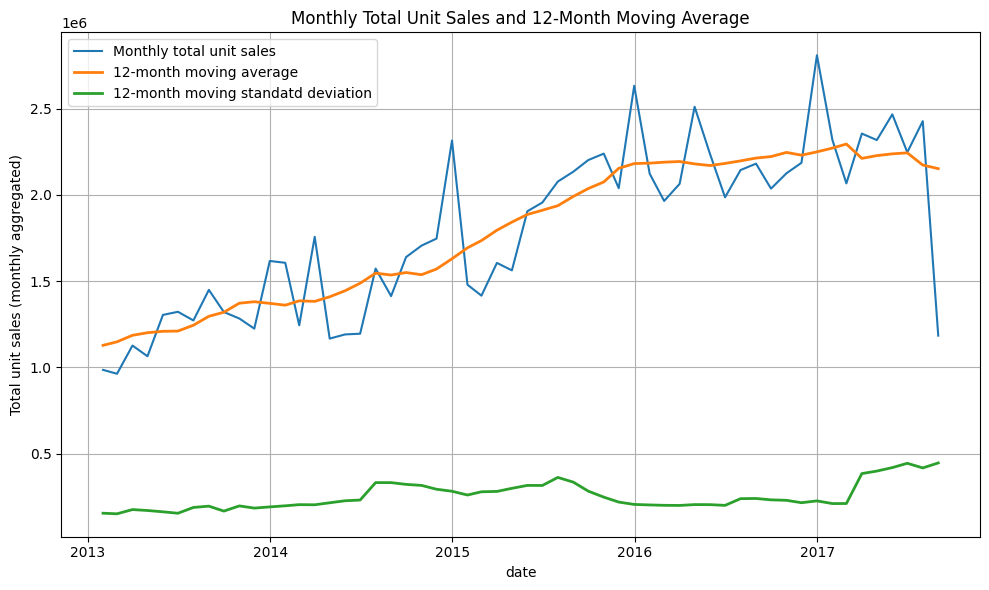

In [2016]:

# 1. Monthly total (daily unit sales aggregated to month level)
df['month'] = df.index.month 
df_monthly = df.resample('M').sum()

# 2. 12-month rolling average and std on monthly totals
df_monthly['unit_sales_ma_12'] = df_monthly['unit_sales'].rolling(window=12, min_periods=6, center=True).mean()
df_monthly['unit_sales_std_12'] = df_monthly['unit_sales'].rolling(window=12, min_periods=6, center=True).std()

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(df_monthly.index, df_monthly['unit_sales'], label="Monthly total unit sales")
plt.plot(df_monthly.index, df_monthly['unit_sales_ma_12'], label="12-month moving average", linewidth=2)
plt.plot(df_monthly.index, df_monthly['unit_sales_std_12'], label="12-month moving standatd deviation", linewidth=2)

plt.xlabel("date")
plt.ylabel("Total unit sales (monthly aggregated)")
plt.title("Monthly Total Unit Sales and 12-Month Moving Average")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

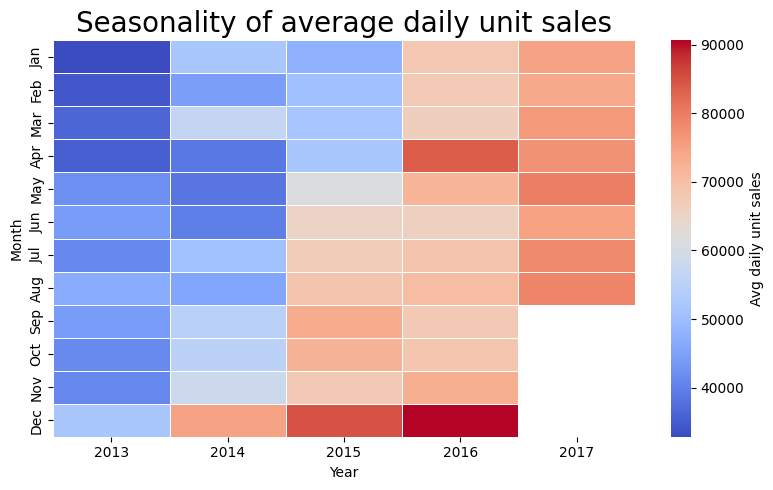

In [2017]:

# 1. Add year and month-name
df_monthly_avg = df_monthly_avg.copy()
df_monthly_avg['year'] = df_monthly_avg.index.year # type: ignore
df_monthly_avg['month_name'] = df_monthly_avg.index.strftime('%b')   # Jan, Feb, ...

# 2. Right order of months (not asc order, just like in the real calendar)
month_order = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

df_monthly_avg['month_name'] = pd.Categorical(
    df_monthly_avg['month_name'],
    categories=month_order,
    ordered=True
)

# 3. Build Pivot-table: row = months, columns = years, values = average unit sales rate
sales_pivot_avg = df_monthly_avg.pivot(
    index='month_name',
    columns='year',
    values='unit_sales'
)

#print(sales_pivot_avg) 

# 4. Build heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    sales_pivot_avg,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Avg daily unit sales'}
)

plt.title('Seasonality of average daily unit sales', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

In [2018]:
display(df.head())

,unit_sales,year,weekday,is_workday,month
date,,,,,
2013-01-02,42320.0,2013,2,True,1
2013-01-03,32708.0,2013,3,True,1
2013-01-04,30847.0,2013,4,True,1
2013-01-05,42351.0,2013,5,False,1
2013-01-06,43988.0,2013,6,False,1


## Resume

#Укр

Продажі демонструють стабільний типовий рівень, про що свідчить медіана на рівні приблизно 58 тис. одиниць на день.

Коефіцієнт асиметрії (skewness ≈ 0.68) вказує, що розподіл щодобових продажів є помірно правостороннім. Це означає, що в більшості днів продажі знаходяться в нормальному діапазоні, однак періодично виникають поодинокі високі піки (пов’язані зі святами, акціями чи сезонними подіями), які формують «довгий хвіст» праворуч. Позитивний коефіцієнт ексцесу (kurtosis ≈ 1.48) підтверджує наявність екстремальних значень. 

Розподіл має вищий пік та «важкі хвости», що свідчить про концентрацію більшості днів поблизу середнього рівня продажів та про епізодичні різкі сплески (промо-активності, сезонні піки). 

Загалом, такі характеристики розподілу є типовими для ритейлових часових рядів і вказують на нерівномірність попиту, що необхідно враховувати під час моделювання — наприклад, застосовуючи лог-трансформацію, детекцію аномалій або корекцію сезонності.

Аналіз щоденних продажів за роками показує чіткий висхідний тренд: медіана та загальний рівень продажів зростають з 2013 по 2017 роки. Одночасно збільшується варіативність — інтервали значень ширшають, а кількість викидів (пік продажів у окремі дні, здебільшого пов’язані з промо чи святами) зростає. У кожному році присутні поодинокі дні з нульовими продажами. Загалом дані демонструють стабільне зростання попиту, але водночас — підвищену нерівномірність та наявність аномальних пікових днів.

Теплова карта демонструє чітку та стабільну сезонну закономірність.
Продажі стабільно найнижчі у період з січня по березень, зростають навесні та влітку, а в грудні щороку різко досягають піку. Така сезонна форма повторюється щорічно, тоді як загальний рівень продажів зростає з року в рік. Грудень показує найвищий попит, причому 2016 рік особливо виділяється надзвичайно високим святковим піком.

#Eng

Daily sales exhibit a stable typical level, as indicated by a median value of approximately 58,000 units per day.

The skewness coefficient (skewness ≈ 0.68) shows that the distribution of daily sales is moderately right-skewed. This means that on most days sales fall within a normal or expected range, but there are occasional high positive spikes (associated with holidays, promotions, or seasonal events) that create a noticeable right-hand tail.

The positive excess kurtosis (kurtosis ≈ 1.48) further confirms the presence of extreme values. The distribution has a sharper peak and heavier tails compared to a normal distribution, indicating that while most days cluster around the average sales level, there are also episodic sharp increases caused by promotional activities or seasonal demand peaks.

Overall, these characteristics are typical for retail time series and indicate non-uniform demand, which should be taken into account during modeling — for example, by applying log-transformation, detecting outliers, or adjusting for seasonality.

The year-by-year analysis of daily sales shows a clear upward trend: both the median and overall sales levels steadily increase from 2013 to 2017. At the same time, variability grows, with wider interquartile ranges and an increasing number of outliers—sharp daily spikes typically linked to promotions or seasonal events. Each year also contains occasional days with zero sales, which is common in retail data. Overall, the distribution indicates stable demand growth combined with rising irregularity and more frequent extreme sales days.

The heatmap reveals a clear and stable seasonal pattern.
Sales are consistently lowest in January–March, rise through spring and summer, and peak sharply in December every year. This seasonal shape repeats annually, while the overall level of sales increases year by year. December shows the strongest demand, with 2016 standing out as an exceptionally high holiday peak.

## Time Series Decomposition
Виходячи з графіку з щоденними даними - ряд df["unit_sales"] нестаціонарний:
- видно зростаючий тренд (поступове підвищення рівня продажів з року в рік)
- сезонні піки (ймовірно святковий або акційний період)
- зміна дисперсія

KPSS-test також підтверджує висновок про нестаціонарність ряду:

In [2019]:
def kpss_report(series):
    statistic, p_value, _, _ = kpss(series.dropna(), regression='c')
    print("KPSS p-value:", p_value)
    if p_value < 0.05:
        print("Ряд нестаціонарний (відхиляємо H0)")
    else:
        print("Ряд стаціонарний (не відхиляємо H0)")

kpss_report(df["unit_sales"])

KPSS p-value: 0.01
Ряд нестаціонарний (відхиляємо H0)


/tmp/ipykernel_45287/1647711667.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(series.dropna(), regression='c')


Ряд мультиплікативний (аплітуди збільшується при зростанні середнього рівня)
Спробуємо провести декомпозицію ряду.
1. Сезонна декомпозиція за допоомгою seasonal_decompose: Логарифмування ряду + аддитивна модель. Сезонність тижнева.
В графіку тренду все ще присутня річна сезонність - мультисезонність? Чи ефект "нульових продажів"?

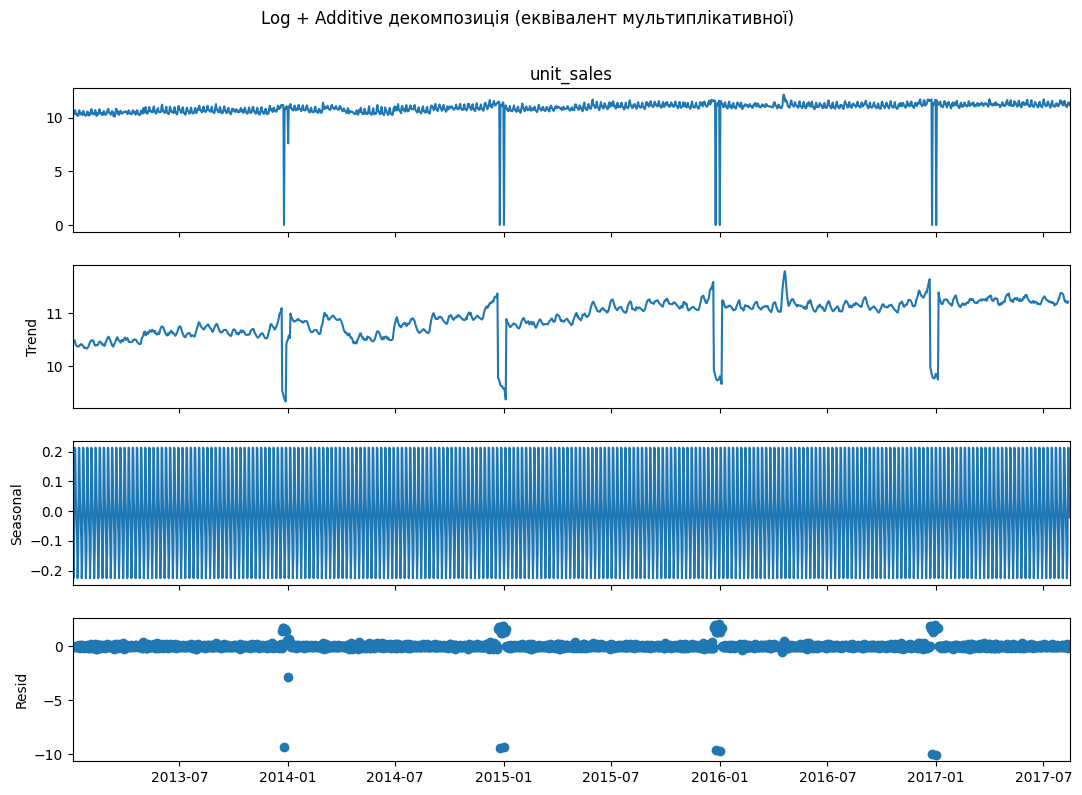

In [2022]:
y_log = np.log1p(df["unit_sales"])

decomp_log= seasonal_decompose(y_log, model="additive", period=7)
fig = decomp_log.plot()
fig.set_size_inches(12, 8)
plt.suptitle("Log + Additive декомпозиція (еквівалент мультиплікативної)", y=1.02)
plt.show()

2. Мультисезонна декомпозиція з використанням MSTL:


Seasonal columns: Index(['seasonal_7', 'seasonal_365'], dtype='object')


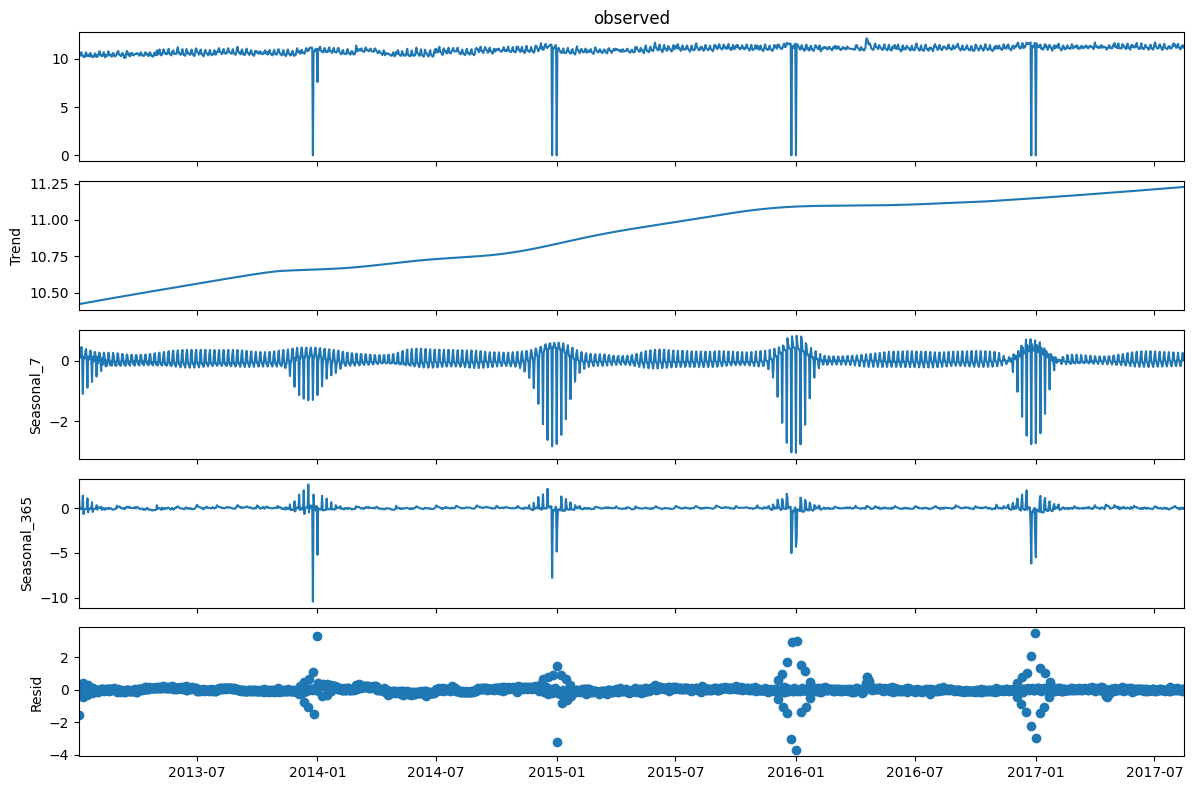

In [2020]:

from statsmodels.tsa.seasonal import MSTL

y = df["unit_sales"]
y_log = np.log1p(y)  

mstl_res = MSTL(endog=y_log, periods=(7, 365)).fit()

trend_log = mstl_res.trend
seasonal_log = mstl_res.seasonal
resid_log = mstl_res.resid

print("Seasonal columns:", seasonal_log.columns)

# вибираємо сезонності
season_week_log = seasonal_log["seasonal_7"]
season_year_log = seasonal_log["seasonal_365"]

components_log = pd.DataFrame({
    "trend_log": trend_log,
    "season_week_log": season_week_log,
    "season_year_log": season_year_log,
    "resid_log": resid_log,
}, index=df.index)

# print(components_log.head())

fig = mstl_res.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

Перевірка стаціонарності залишків моделі MSTL

In [2021]:

def adf_report(series, regression='ct'):
    result = adfuller(series.dropna(), regression=regression)
    p_value = result[1]
    if p_value < 0.05:
        print("Ряд стаціонарний (відхиляємо H0)")
    else:
        print("Ряд нестаціонарний (не відхиляємо H0)")
    print(f"p-value: {p_value:.2f}")
adf_report(resid_log, regression='c')

Ряд стаціонарний (відхиляємо H0)
p-value: 0.00


# Висновки: 
- доцільно застосувати логарифмування df["unit_sales"], це дозволить перейти від мультиплікативної моделі до аддитивної;
- маємо мультисезонність (чітка тижнева і річна в період зимових свят)
- маємо зростаючий тренд.
- залишки моделі MSTL стаціонарні, коливаються навколо 0, проте містять аномальні викиди в період зимових свят. Можливо додати екзогенну змінну зі святами буде доцільним. 
- модель MSTL перспективна для прогнозування -  (наприклад, MSTL + ARIMA/SARIMAX на залишках)
- Prophet як варіант для врахування мультисезонності та свята
